Generated images will be saved in ./generated_images/monet2photo
GPU is enabled 



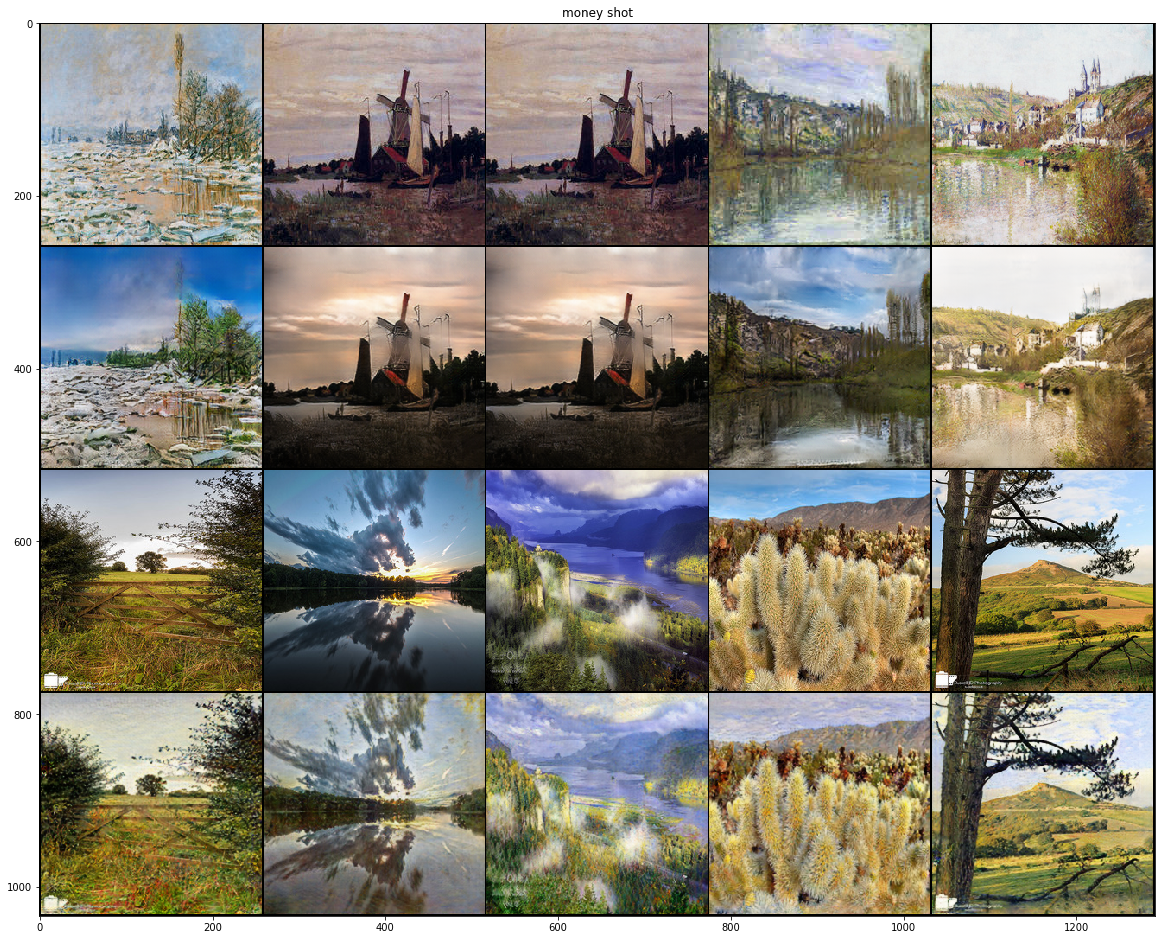

In [1]:
import argparse
import sys
import os
import numpy as np
import math
import itertools
import datetime
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image

%matplotlib inline  


from src_code.models import *
from src_code.data_loader import *

######################################
# Hyperparameters
######################################

# epoch to start training from
start_epoch = 164

# dataset name
dataset_name = "monet2photo"

# validation batch size
val_batch_size = 5

# training image height
img_height= 256

# training image width
img_width = 256


######################################


# Make directory for generated images and model checkpoints
os.makedirs('generated_images/%s' % dataset_name, exist_ok=True)
print("Generated images will be saved in ./generated_images/%s" % dataset_name)


#############################################
# Load datasets
#############################################
# Validation set
val_dataloader = DataLoader(CycleGAN_Dataset("datasets/%s/testA/" % dataset_name, "datasets/%s/testB/" % dataset_name, img_height, img_width),batch_size=val_batch_size, num_workers=1)
#############################################


###############################################
# Create Networks and initialize weights
###############################################
# Generator and Discriminator Networks
G_AB = ResNet_Generator(res_blocks=9)
G_BA = ResNet_Generator(res_blocks=9)

# Prep GPU
GPU = torch.cuda.is_available()
print("GPU is {}enabled \n".format(['not ', ''][GPU]))

if GPU:
    G_AB = G_AB.cuda()
    G_BA = G_BA.cuda()

G_AB.load_state_dict(torch.load('checkpoints/%s/G_AB_%d.pth' % (dataset_name, start_epoch)))
G_BA.load_state_dict(torch.load('checkpoints/%s/G_BA_%d.pth' % (dataset_name, start_epoch)))
###############################################

#####################################
# Generate Validation images
#####################################
def generate_val_imgs():
    val_imgs = next(iter(val_dataloader))

    val_real_A = Variable(torch.FloatTensor(val_imgs['A']))
    val_real_B = Variable(torch.FloatTensor(val_imgs['B']))
    if GPU:
        val_real_A = val_real_A.cuda()
        val_real_B = val_real_B.cuda()

    val_fake_A = G_BA(val_real_B.detach())
    val_fake_B = G_AB(val_real_A.detach())

    stacked_image = torch.cat((val_real_A.data, val_fake_B.data, val_real_B.data, val_fake_A.data), 0)
    save_image(stacked_image, 'generated_images/%s/demo.png' % (dataset_name), nrow=val_batch_size, normalize=True)
    
#####################################

generate_val_imgs()

img = plt.imread('generated_images/monet2photo/demo.png')
plt.figure(figsize=(20,20))
plt.imshow(img)
plt.title("money shot")
plt.show()
